# Intel®-Optimized TensorFlow Histology Demo

This demo uses the [colorectal histology images dataset](https://www.tensorflow.org/datasets/catalog/colorectal_histology) to train a simple convolutional neural network in TensorFlow. 

All images are RGB, 0.495 µm per pixel, digitized with an Aperio ScanScope (Aperio/Leica biosystems), magnification 20x. Histological samples are fully anonymized images of formalin-fixed paraffin-embedded human colorectal adenocarcinomas (primary tumors) from our pathology archive (Institute of Pathology, University Medical Center Mannheim, Heidelberg University, Mannheim, Germany).

https://zenodo.org/record/53169#.X1bMe3lKguX
Kather, J. N., Zöllner, F. G., Bianconi, F., Melchers, S. M., Schad, L. R., Gaiser, T., … Weis, C.-A. (2016). Collection of textures in colorectal cancer histology [Data set]. Zenodo. http://doi.org/10.5281/zenodo.53169

Kather JN, Weis CA, Bianconi F, Melchers SM, Schad LR, Gaiser T, Marx A, Zollner F: Multi-class texture analysis in colorectal cancer histology (2016), Scientific Reports (in press)

@article{kather2016multi,
  title={Multi-class texture analysis in colorectal cancer histology},
  author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
  journal={Scientific reports},
  volume={6},
  pages={27988},
  year={2016},
  publisher={Nature Publishing Group}
}

In [1]:
!pip install tensorflow_datasets   # Install TensorFlow Datasets

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Determine what type of CPU we are using
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              24
On-line CPU(s) list: 0-23
Thread(s) per core:  2
Core(s) per socket:  6
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
Stepping:            4
CPU MHz:             1200.132
CPU max MHz:         3700.0000
CPU min MHz:         1200.0000
BogoMIPS:            6800.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            19712K
NUMA node0 CPU(s):   0-5,12-17
NUMA node1 CPU(s):   6-11,18-23
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dt

In [3]:
# export TF_DISABLE_MKL=1
os.environ["TF_DISABLE_MKL"]  = "0"  # Disable Intel optimizations

# export MKLDNN_VERBOSE=1
#os.environ["MKLDNN_VERBOSE"]  = "1"     # 1 = Print log statements; 0 = silent

os.environ["OMP_NUM_THREADS"] = "12"   # Number of physical cores
os.environ["KMP_BLOCKTIME"]   = "1"    

# If hyperthreading is enabled, then use
os.environ["KMP_AFFINITY"]    = "granularity=thread,compact,1,0"

# If hyperthreading is NOT enabled, then use
#os.environ["KMP_AFFINITY"]   = "granularity=thread,compact"

import tensorflow as tf

print("TensorFlow version = {}".format(tf.__version__))
print("Does TensorFlow have the Intel optimizations: {}".format(tf.python._pywrap_util_port.IsMklEnabled()))

Is Intel-optimized TensorFlow enabled with DNNL: True


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### NOTE: The download is broken on Windows due to the long filenames in the download. You'll have to manually download and extract on a Windows machine.

In [5]:
(ds), ds_info =  tfds.load('colorectal_histology', data_dir=".", 
                                          shuffle_files=True, split='train', 
                                          with_info=True, as_supervised=True)

assert isinstance(ds, tf.data.Dataset)
print(ds_info)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    version=2.0.0,
    description='Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    total_num_examples=5000,
    splits={
        'train': 5000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      y

## Display a few examples from the dataset

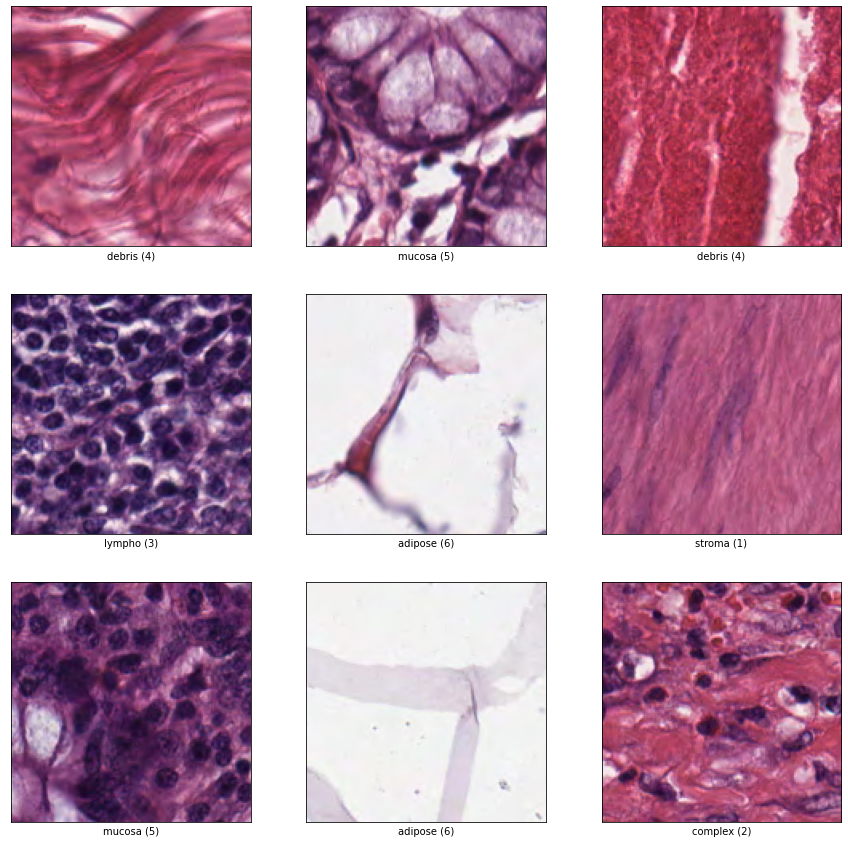

In [6]:
x_key, y_key = ds_info.supervised_keys
ds_temp = ds.map(lambda x, y: {x_key: x, y_key: y})
tfds.show_examples(ds_temp, ds_info, plot_scale=5);

## These are the 8 labels for the histology classification subtypes

In [7]:
ds_info.features['label'].names

['tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty']

## Define the data loaders

This will also do online data augmentation by randomly flipping the images (up/down, left/right)

In [8]:
n = ds_info.splits['train'].num_examples
train_split_percentage = 0.80
train_batch_size = 128
test_batch_size = 16

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def augment_img(image, label):
    """Augment images: `uint8` -> `float32`."""
    
    image = tf.image.random_flip_left_right(image) # Random flip Left/Right
    image = tf.image.random_flip_up_down(image)    # Random flip Up/Down
    
    return tf.cast(image, tf.float32) / 255., label # Normalize 0 to 1 for pixel values

# Get train dataset
ds_train = ds.take(int(n * train_split_percentage))
ds_train = ds_train.map(
    augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(int(n * train_split_percentage))
ds_train = ds_train.batch(train_batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Get test dataset
ds_test = ds.skip(int(n * train_split_percentage)).map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(test_batch_size)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


## Define Model

Here's a Convolutional neural network model. 

In [9]:
inputs = tf.keras.layers.Input(shape=ds_info.features['image'].shape)
conv = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(inputs)
conv = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(conv)
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv)

conv = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(maxpool)
conv = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv)
concat = tf.keras.layers.concatenate([maxpool, conv])
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(concat)

conv = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(maxpool)
conv = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv)
concat = tf.keras.layers.concatenate([maxpool, conv])
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(concat)

conv = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(maxpool)
conv = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv)
concat = tf.keras.layers.concatenate([maxpool, conv])
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(concat)

flat = tf.keras.layers.Flatten()(maxpool)
dense = tf.keras.layers.Dense(128)(flat)
drop = tf.keras.layers.Dropout(0.5)(dense)

predict = tf.keras.layers.Dense(ds_info.features['label'].num_classes)(drop)

model = tf.keras.models.Model(inputs=[inputs], outputs=[predict])

model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=[tf.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 75, 75, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Train the model on the dataset

### Model Checkpoints

Save the model that performs best on the validation dataset

In [10]:
# Create a callback that saves the model
model_dir = "checkpoints"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_dir, 
                                                         save_best_only=True,
                                                         verbose=1)

### Early Stopping

Stop training if the validation doesn't improve after a certain number of epochs

In [11]:
# Create callback for Early Stopping of training
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=8) # Stop once validation loss plateaus for patience epochs

### Adding TensorBoard

Adding TensorBoard logs

In [12]:
# TensorBoard logs
tb_logs_dir = "logs"
os.makedirs(tb_logs_dir, exist_ok=True)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logs_dir)

## Call *fit* to train the model

In [13]:
def train_model(epochs):
    history = model.fit(
        ds_train,
        epochs=epochs,     
        validation_data=ds_test,
        callbacks=[checkpoint_callback, early_stopping_callback, tb_callback]
    )
    return history
    
epochs = 5   # Run for this many epochs - Increase if you have some time
history = train_model(epochs)

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 1.9601 - sparse_categorical_accuracy: 0.3668
Epoch 00001: val_loss improved from inf to 0.99374, saving model to checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


32/32 [==============================] - 98s 3s/step - loss: 1.9601 - sparse_categorical_accuracy: 0.3668 - val_loss: 0.9937 - val_sparse_categorical_accuracy: 0.5760
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.9618 - sparse_categorical_accuracy: 0.5953
Epoch 00002: val_loss improved from 0.99374 to 0.89965, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


32/32 [==============================] - 90s 3s/step - loss: 0.9618 - sparse_categorical_accuracy: 0.5953 - val_loss: 0.8997 - val_sparse_categorical_accuracy: 0.6470
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.8211 - sparse_categorical_accuracy: 0.6885
Epoch 00003: val_loss improved from 0.89965 to 0.73123, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


32/32 [==============================] - 90s 3s/step - loss: 0.8211 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.7312 - val_sparse_categorical_accuracy: 0.7310
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.7463 - sparse_categorical_accuracy: 0.7075
Epoch 00004: val_loss improved from 0.73123 to 0.71963, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


32/32 [==============================] - 89s 3s/step - loss: 0.7463 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.7610
Epoch 5/5
32/32 [==============================] - ETA: 0s - loss: 0.7752 - sparse_categorical_accuracy: 0.6892
Epoch 00005: val_loss did not improve from 0.71963
32/32 [==============================] - 87s 3s/step - loss: 0.7752 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.8089 - val_sparse_categorical_accuracy: 0.6960


## Plot training curves

In [14]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

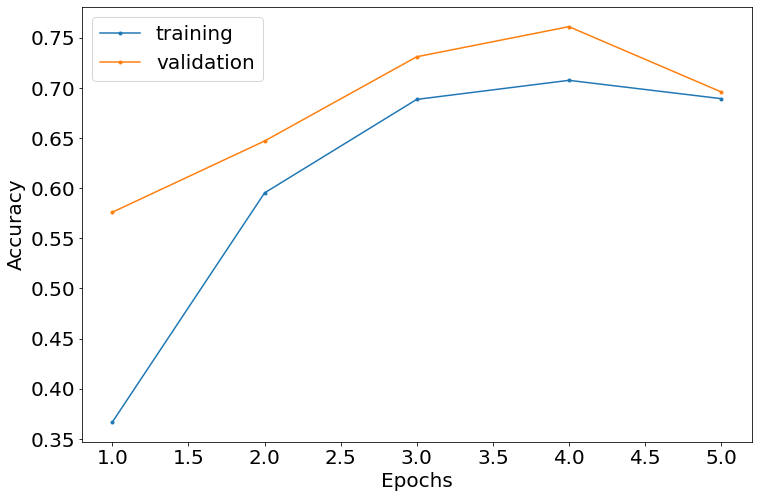

In [15]:
plt.figure(figsize=(12,8));
plt.plot(range(1,epochs+1), history.history['sparse_categorical_accuracy'], '.-');
plt.plot(range(1,epochs+1), history.history['val_sparse_categorical_accuracy'], '.-');
plt.legend(['training', 'validation'], fontsize=20);
plt.xticks(size=20);
plt.xlabel('Epochs', size=20);
plt.yticks(size=20);
plt.ylabel('Accuracy', size=20);


## Load the best model

In [16]:
print("Loading model that had the highest score on the validation dataset")
model = tf.keras.models.load_model(model_dir)

Loading model that had the highest score on the validation dataset


## Evaluate the best model on the test dataset

In [17]:
print("Evaluating the best model on the test dataset")
_, accuracy = model.evaluate(ds_test)
print("\nModel accuracy on test dataset = {:.1f}%".format(100.0*accuracy))

Evaluating the best model on the test dataset
63/63 [==============================] - 6s 92ms/step - loss: 0.7196 - sparse_categorical_accuracy: 0.7610

Model accuracy on test dataset = 76.1%


## Display some predictions on the test data

We grab a random subset of the test dataset and plot the image along with the ground truth label, the TensorFlow model prediction, and the OpenVINO model prediction.

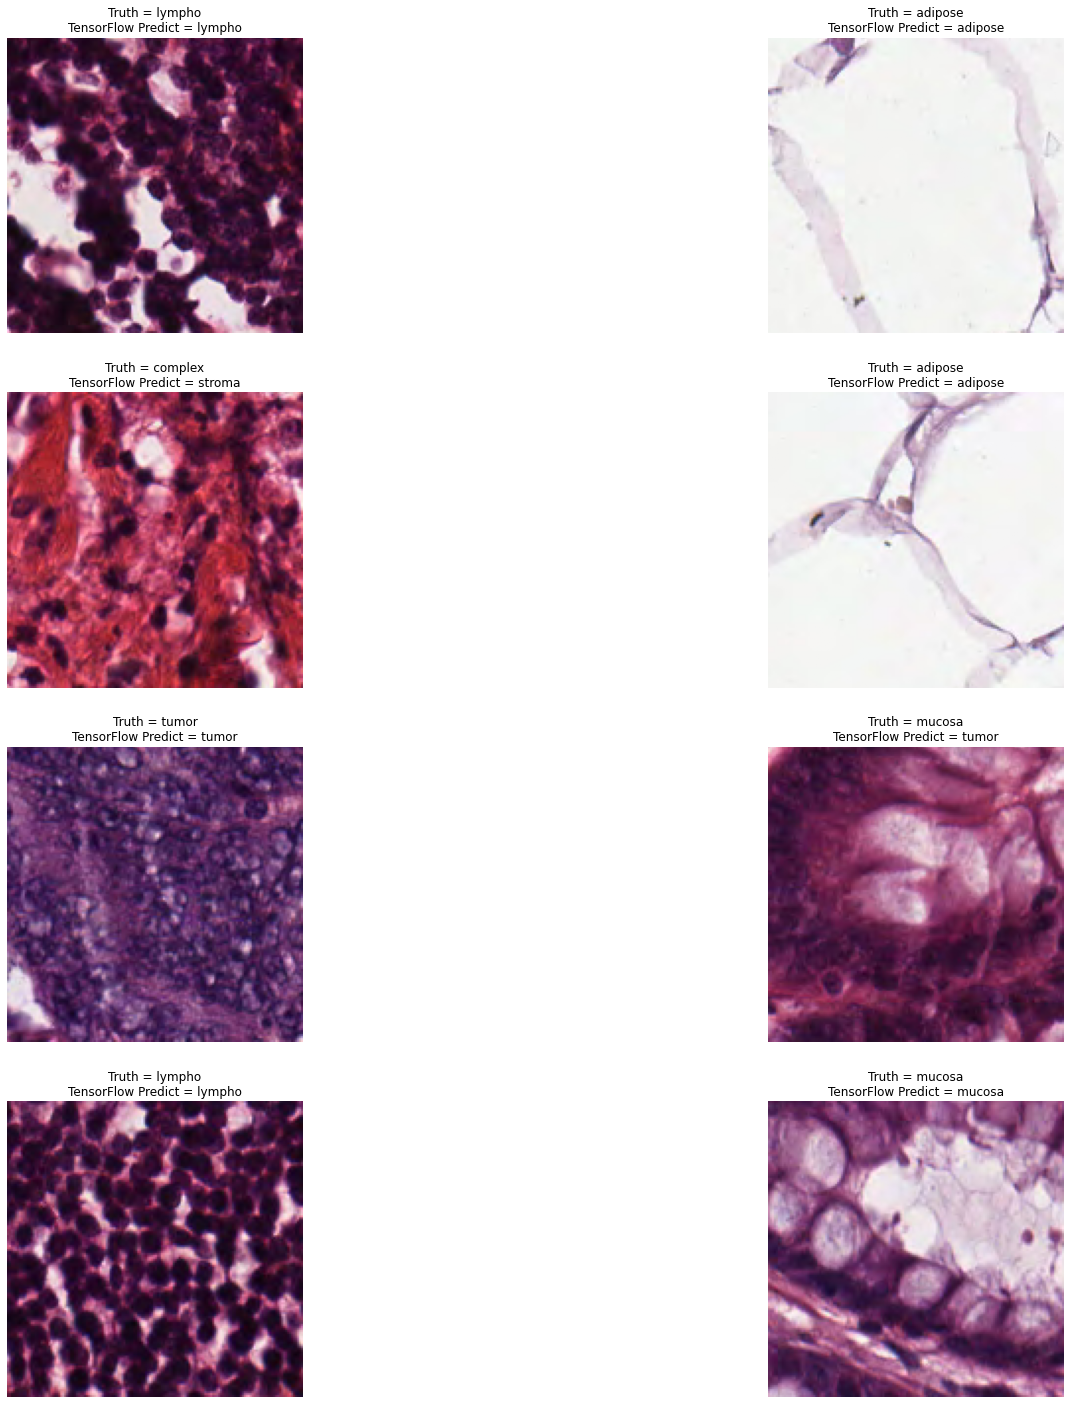

In [18]:
test_data = tfds.as_numpy(ds_test.shuffle(100).take(1)) # Take 1 random batch

for image, label in test_data:
    num = 8 # len(label)
    cols = 2
    plt.figure(figsize=(25,25))
    
    for idx in range(num):
        
        plt.subplot(int(np.ceil(num/cols)), cols, idx+1)
        plt.imshow(image[idx])
        plt.axis("off")
        
        # TensorFlow model prediction
        tf_predict = ds_info.features['label'].names[model.predict(image[[idx]]).argmax()]
        
        plt.title("Truth = {}\nTensorFlow Predict = {}".format(ds_info.features['label'].names[label[idx]], tf_predict))
        